In [115]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# データ取得

In [116]:
# Binanceのインスタンスを作成（レートリミットを有効化）
exchange = ccxt.binance({
    'enableRateLimit': True,
})

# BTC/USDTのデータを取得
symbol = 'BTC/USDT'
timeframe = '1h'  # 1時間足のデータ
since = exchange.parse8601('2018-01-01T00:00:00Z')  # データの開始日

# データを取得する関数（例外処理と進行状況の追加）
def fetch_all_ohlcv(symbol, timeframe, since):
    all_ohlcv = []
    now = exchange.milliseconds()
    while since < now:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=1000)
            if not ohlcv:
                break
            since = ohlcv[-1][0] + 1  # タイムスタンプを更新
            all_ohlcv.extend(ohlcv)
        except Exception as e:
            print(f'An error occurred: {e}')
            # リトライのために一時停止
            time.sleep(5)
            continue
    return all_ohlcv

# データを取得
ohlcv = fetch_all_ohlcv(symbol, timeframe, since)
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# タイムスタンプを変換
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# CSVファイルとして保存
data.to_csv('btc_usdt_1h_2018_to_now.csv', index=False)

print('Data fetching and saving completed.')

Data fetching and saving completed.


In [117]:
# データの読み込みと文字列として保存されている日時情報を日時型のデータに変換
df = pd.read_csv("btc_usdt_1h_2018_to_now.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [118]:
# タイムスタンプでソートとインデックスのリセット
df.sort_values('timestamp', inplace=True)#inplaceで新しいdataframeを作成せず元のを変更
# 列をインデックス（行ラベル）として設定
df.set_index('timestamp', inplace=True)

In [119]:
# 特徴量エンジニアリング
# 移動平均線の計算
df['SMA_5'] = df['close'].rolling(window=5).mean()
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_75'] = df['close'].rolling(window=75).mean()
df['SMA_100'] = df['close'].rolling(window=100).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# 指数移動平均線の計算
df['EMA_5'] = df['close'].ewm(span=5, adjust=False).mean() #ewmはEMAを計算するためのpandasメソッド
df['EMA_10'] = df['close'].ewm(span=10, adjust=False).mean() #adjustは新しいデータに強く重みづけ
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_30'] = df['close'].ewm(span=30, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
df['EMA_75'] = df['close'].ewm(span=75, adjust=False).mean()
df['EMA_100'] = df['close'].ewm(span=100, adjust=False).mean()
df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()

# RSIの計算
def compute_RSI(data, time_window):
    diff = data.diff(1) #1つ前の行との違い
    up_chg = diff.clip(lower=0) #差分が負の物は0に変換
    down_chg = -diff.clip(upper=0) #差分が0より大きいものを全て0に置き換える
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean() #価格が上昇した指数移動平均
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    rs = up_chg_avg / down_chg_avg #上昇した強さと下落した強さの比率
    rsi = 100 - 100 / (1 + rs) 
    return rsi

df['RSI_14'] = compute_RSI(df['close'], 14)

# MACDの計算
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# ボリンジャーバンドの計算
df['STD_20'] = df['close'].rolling(window=20).std() #stdは標準偏差(データのばらつき度合い)を計算
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

# 遅延特徴量の作成
for lag in range(1, 6): #shift(lag) は、df['close'] のデータを lag 分だけ下にシフト
    df[f'lag_{lag}'] = df['close'].shift(lag) #lag_1からlag_5 までの5つの遅延列が作成

# 時間に関する特徴量
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek #曜日は0から6の値で表される

In [120]:
# 目標変数の作成
df['return'] = df['close'].pct_change().shift(-1) #前の行とのパーセンテージの変化
df['target'] = (df['return'] > 0).astype(int) #価格が上昇したらTrue

In [121]:
# 欠損値の削除
df.dropna(inplace=True)

In [122]:
# 特徴量と目標変数の定義
features = ['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_30', 'SMA_50', 'SMA_75', 'SMA_100', 'SMA_200',
            'EMA_5', 'EMA_10', 'EMA_20', 'EMA_30', 'EMA_50', 'EMA_75', 'EMA_100', 'EMA_200', 'RSI_14', 'MACD', 'Signal_Line',
            'Upper_Band', 'Lower_Band', 'hour', 'day_of_week'] + [f'lag_{lag}' for lag in range(1,6)]
X = df[features]
y = df['target'] #価格が上昇すれば1下落すれば0

In [123]:
# データの分割（時間ベースでの分割）
split_date = '2024-09-30'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [124]:
# LightGBM用のデータセットを作成
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# パラメータの設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
}

# モデルの訓練
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_train, lgb_eval],
                num_boost_round=1000,
                callbacks=[lgb.early_stopping(stopping_rounds=50)])

# 予測の実行
print('Making predictions...')
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int)

Starting training...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.673712	valid_1's binary_logloss: 0.689253
Making predictions...


In [125]:
# モデルの評価
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5207253886010362
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       195
           1       0.52      0.52      0.52       191

    accuracy                           0.52       386
   macro avg       0.52      0.52      0.52       386
weighted avg       0.52      0.52      0.52       386



Final capital: 1233.6299785774297
Sharpe Ratio: 6.007227321939844


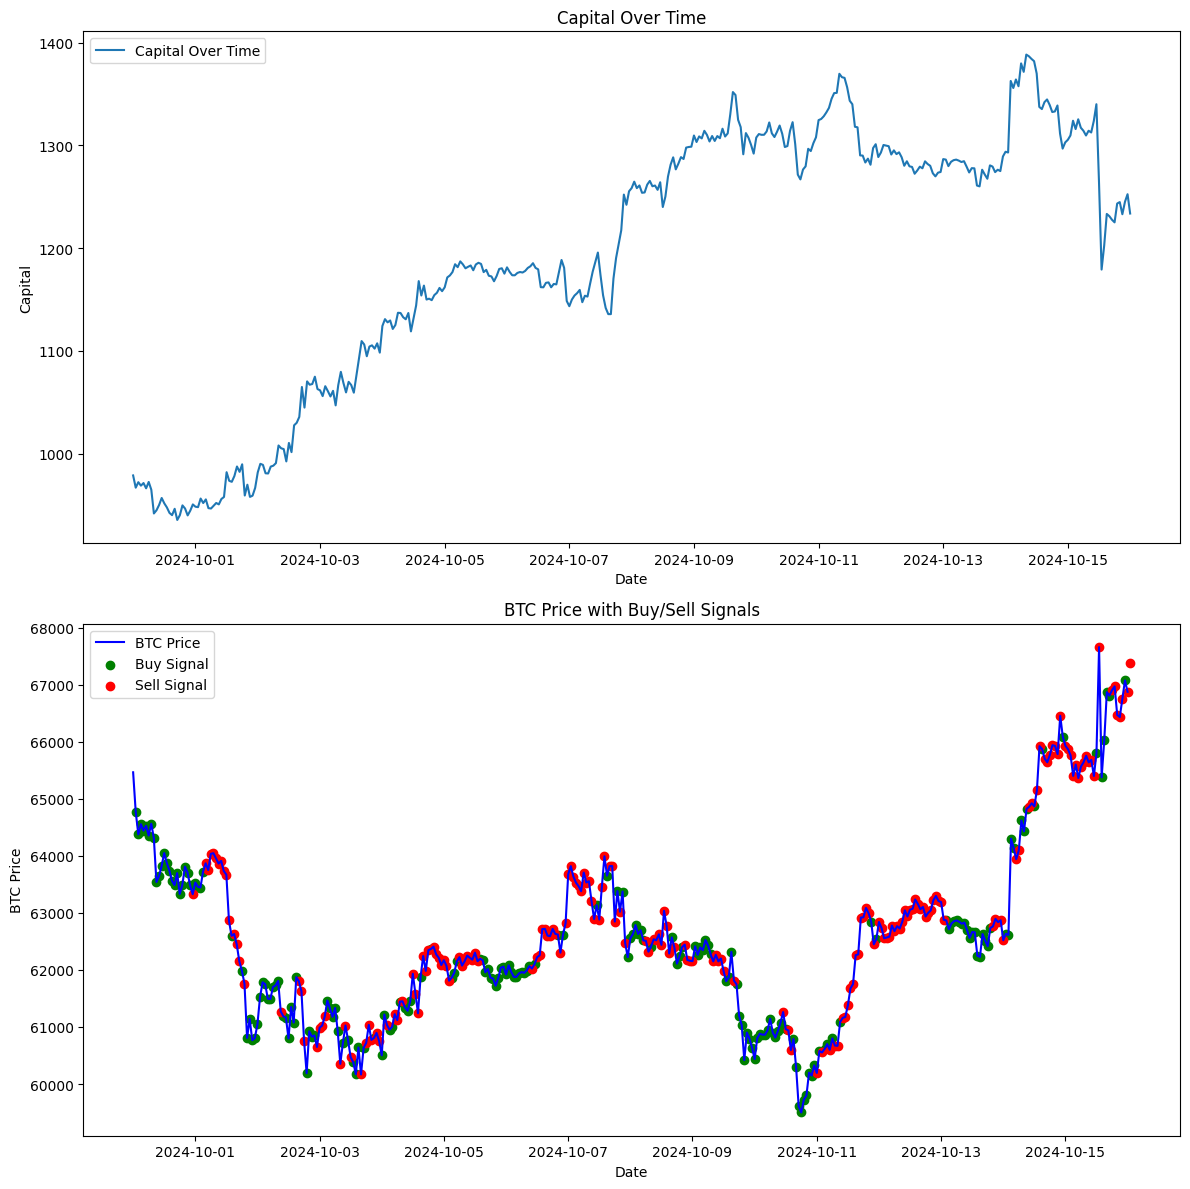

In [126]:
# バックテストの実行
# 取引シミュレーション
capital = initial_capital  # 初期資金をリセット
capital_history = []
positions = []
buy_signals = []
sell_signals = []

for i in range(len(test_dates)-1):
    date = test_dates[i]
    prediction = y_pred[i]
    close_price = df.loc[date, 'close']
    next_date = test_dates[i+1]
    next_close_price = df.loc[next_date, 'close']
    
    # ポジションの決定
    if prediction == 1:
        position = 1  # ロング
        buy_signals.append((next_date, next_close_price))  # 買いのシグナル
    else:
        position = -1  # ショート
        sell_signals.append((next_date, next_close_price))  # 売りのシグナル
    
    # リターンの計算
    ret = (next_close_price - close_price) / close_price * position * leverage
    capital = capital * (1 + ret)
    capital_history.append(capital)
    positions.append(position)

# バックテスト結果のデータフレーム作成
backtest_results = pd.DataFrame(index=test_dates[:-1])
backtest_results['Capital'] = capital_history
backtest_results['Position'] = positions

# リターンの計算
backtest_results['Return'] = backtest_results['Capital'].pct_change().fillna(0)

# シャープレシオの計算（リスクフリーレートは0と仮定）
sharpe_ratio = (backtest_results['Return'].mean() / backtest_results['Return'].std()) * np.sqrt(365 * 24)

print('Final capital:', capital)
print('Sharpe Ratio:', sharpe_ratio)

# 資産推移と売買のプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)  # 2行1列のグラフの1番目
plt.plot(backtest_results.index, backtest_results['Capital'], label='Capital Over Time')
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)  # 2行1列のグラフの2番目
plt.plot(df.loc[test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()


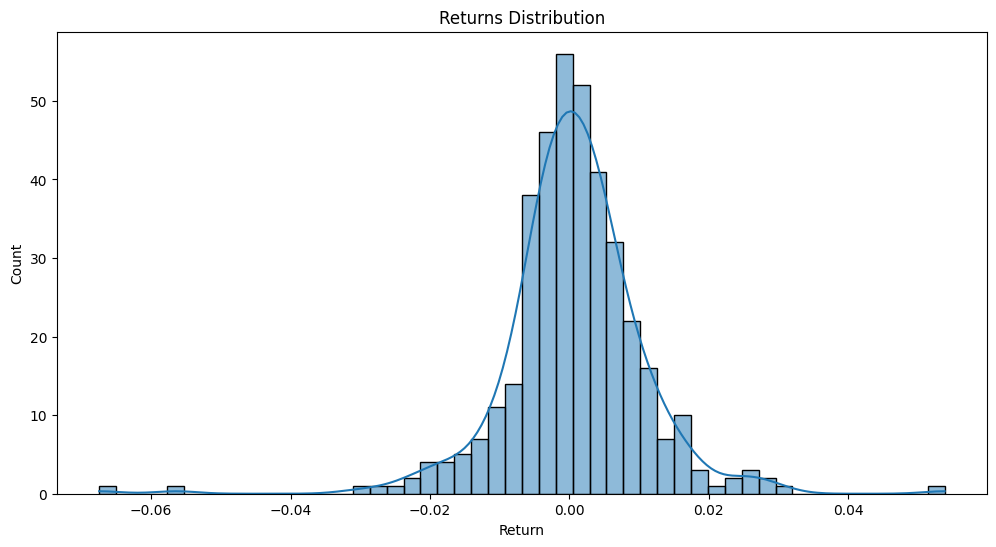

In [128]:
# リターン分布のプロット
plt.figure(figsize=(12,6))
sns.histplot(backtest_results['Return'], bins=50, kde=True)
plt.title('Returns Distribution')
plt.show()

In [129]:
# モデルの保存
gbm.save_model('lightgbm_btc_model.txt')

In [130]:
# NaNの確認
print("Checking for NaNs in X_train:", X_train.isnull().any())
print("Checking for NaNs in y_train:", y_train.isnull().any())

# 無限大の確認
print("Checking for infinite values in X_train:", np.isinf(X_train).any())
print("Checking for infinite values in y_train:", np.isinf(y_train).any())


Checking for NaNs in X_train: open           False
high           False
low            False
close          False
volume         False
SMA_5          False
SMA_10         False
SMA_20         False
SMA_30         False
SMA_50         False
SMA_75         False
SMA_100        False
SMA_200        False
EMA_5          False
EMA_10         False
EMA_20         False
EMA_30         False
EMA_50         False
EMA_75         False
EMA_100        False
EMA_200        False
RSI_14         False
MACD           False
Signal_Line    False
Upper_Band     False
Lower_Band     False
hour           False
day_of_week    False
lag_1          False
lag_2          False
lag_3          False
lag_4          False
lag_5          False
dtype: bool
Checking for NaNs in y_train: False
Checking for infinite values in X_train: open           False
high           False
low            False
close          False
volume         False
SMA_5          False
SMA_10         False
SMA_20         False
SMA_30         False

In [131]:
# モデル改良のための次のステップとして、ハイパーパラメータのチューニングを行います
# グリッドサーチによるハイパーパラメータチューニング
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'max_depth': [None, 10],
}

gbm_cv = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1)
grid = GridSearchCV(gbm_cv, param_grid, cv=3)
grid.fit(X_train, y_train)

print('Best parameters found by grid search are:', grid.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 50}


In [132]:
# 最適なパラメータを取得
best_params = grid.best_params_

# パラメータをlgb.train()用に調整
best_params_adjusted = best_params.copy()

# max_depthがNoneの場合、-1に設定（制限なし）
if best_params_adjusted.get('max_depth') is None:
    best_params_adjusted['max_depth'] = -1

# パラメータ名を修正（必要に応じて）
train_params = {**params, **best_params_adjusted}
if 'metric' in train_params:
    train_params['metrics'] = train_params.pop('metric')

# モデルの訓練
gbm_optimized = lgb.train(train_params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          num_boost_round=1000,
                          callbacks=[lgb.early_stopping(stopping_rounds=50)])

# 予測の実行
print('Making predictions...')
y_pred_prob = gbm_optimized.predict(X_test, num_iteration=gbm_optimized.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.682846	valid_1's binary_logloss: 0.691695
Making predictions...


In [133]:
# モデルの評価
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5103626943005182
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       195
           1       0.50      0.53      0.52       191

    accuracy                           0.51       386
   macro avg       0.51      0.51      0.51       386
weighted avg       0.51      0.51      0.51       386



Final capital: 1206.1217671837219
Sharpe Ratio: 5.466505073903342


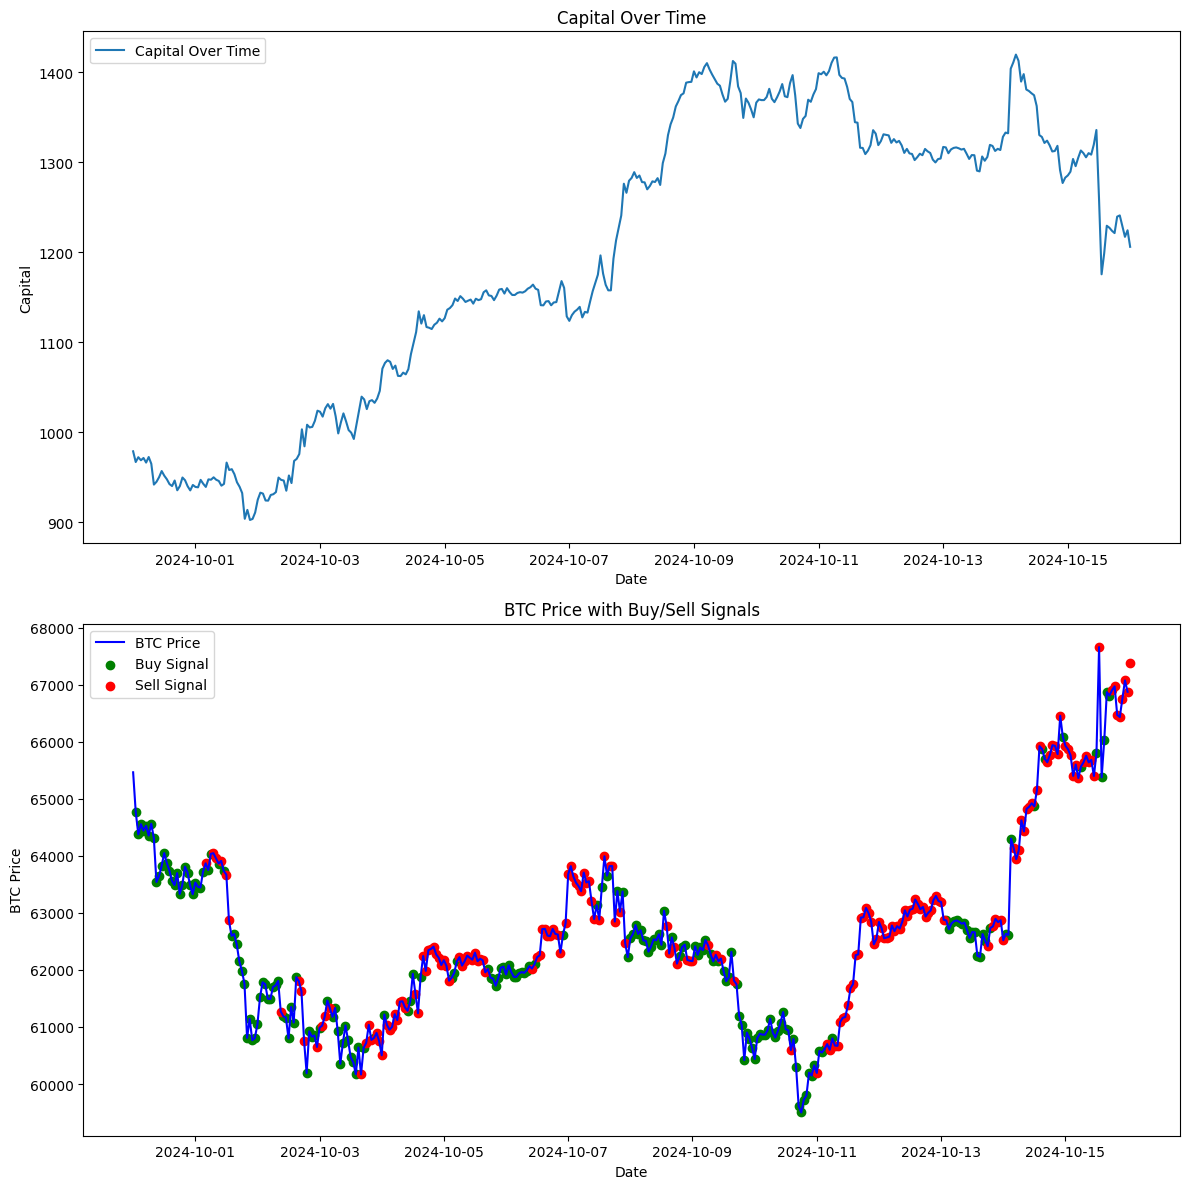

In [134]:
# バックテストの実行
# 取引シミュレーション
capital = initial_capital  # 初期資金をリセット
capital_history = []
positions = []
buy_signals = []
sell_signals = []

for i in range(len(test_dates)-1):
    date = test_dates[i]
    prediction = y_pred[i]
    close_price = df.loc[date, 'close']
    next_date = test_dates[i+1]
    next_close_price = df.loc[next_date, 'close']
    
    # ポジションの決定
    if prediction == 1:
        position = 1  # ロング
        buy_signals.append((next_date, next_close_price))  # 買いのシグナル
    else:
        position = -1  # ショート
        sell_signals.append((next_date, next_close_price))  # 売りのシグナル
    
    # リターンの計算
    ret = (next_close_price - close_price) / close_price * position * leverage
    capital = capital * (1 + ret)
    capital_history.append(capital)
    positions.append(position)

# バックテスト結果のデータフレーム作成
backtest_results = pd.DataFrame(index=test_dates[:-1])
backtest_results['Capital'] = capital_history
backtest_results['Position'] = positions

# リターンの計算
backtest_results['Return'] = backtest_results['Capital'].pct_change().fillna(0)

# シャープレシオの計算（リスクフリーレートは0と仮定）
sharpe_ratio = (backtest_results['Return'].mean() / backtest_results['Return'].std()) * np.sqrt(365 * 24)

print('Final capital:', capital)
print('Sharpe Ratio:', sharpe_ratio)

# 資産推移と売買のプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)  # 2行1列のグラフの1番目
plt.plot(backtest_results.index, backtest_results['Capital'], label='Capital Over Time')
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)  # 2行1列のグラフの2番目
plt.plot(df.loc[test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()


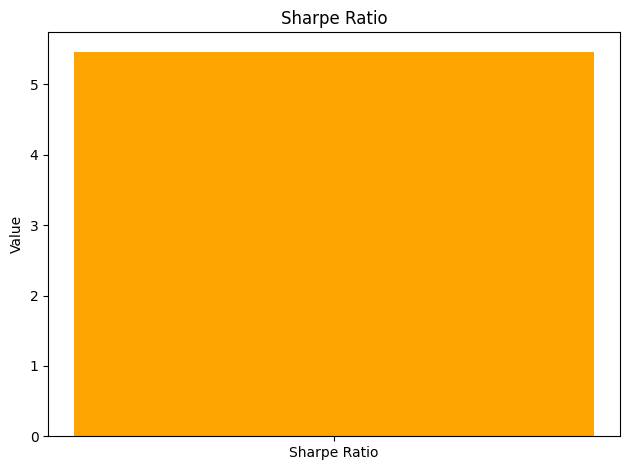

In [135]:
# シャープレシオのプロット（単一の値を表示）
plt.bar(['Sharpe Ratio'], [sharpe_ratio], color='orange')
plt.title('Sharpe Ratio')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

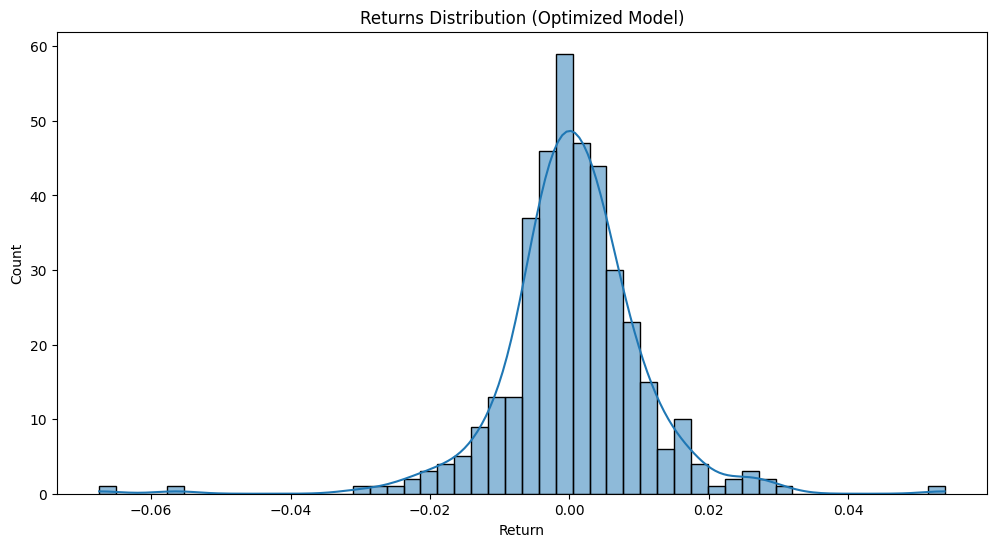

In [136]:
# リターン分布のプロット
plt.figure(figsize=(12,6))
sns.histplot(backtest_results['Return'], bins=50, kde=True)
plt.title('Returns Distribution (Optimized Model)')
plt.show()

In [137]:
# モデルの保存
gbm_optimized.save_model('lightgbm_btc_model_optimized.txt')

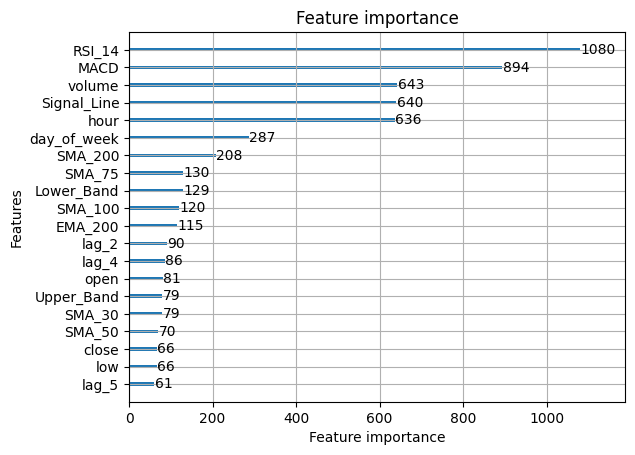

In [138]:
# 特徴量の重要度をプロット
lgb.plot_importance(gbm_optimized, max_num_features=20)
plt.show()